# **Matrix Factorization engine for Recommendations on MovieLens20M dataset**


## Objectives:

- Implement a matrix factorization engine algorithm with Keras.
- Utilize the matrix factorization engine to make predictions on MovieLens20M dataset.

----


### Matrix Factorization

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import math

from IPython.display import display, Math, Latex

%matplotlib inline

In [2]:
from tensorflow import keras
from keras.layers import Input, Dot, Embedding, Dense, Concatenate, Flatten, Dropout
from keras.models import Model
from keras.utils import to_categorical

In [3]:
# also set a random state
rs = 123

The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction.

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)

The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. 

The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.

### Load and explore the dataset

First, let's load the datasets as `Pandas` dataframes and start some basic exploratory data analysis tasks on them.


In [4]:
ratings_df = pd.read_csv('rating.csv')

Let's first take a look at the datasets.

In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
print('Number of rated movies:', ratings_df['movieId'].unique().size,'; number of unique users:', ratings_df['userId'].unique().size) 

Number of rated movies: 26744 ; number of unique users: 138493


Since here we don't use the time stamp for the moment, let us remove it from the user-rating matrix (URM)

In [7]:
urm_df = ratings_df.drop('timestamp',axis=1) 
urm_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [8]:
mu = urm_df['rating'].mean()
urm_df['shifted'] = urm_df['rating'] - mu

In [9]:
urm_df.describe()

,userId,movieId,rating,shifted
count,2.000026e+07,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00,-2.671549e-16
std,4.003863e+04,1.978948e+04,1.051989e+00,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01,-3.025529e+00
25%,3.439500e+04,9.020000e+02,3.000000e+00,-5.255286e-01
50%,6.914100e+04,2.167000e+03,3.500000e+00,-2.552856e-02
75%,1.036370e+05,4.770000e+03,4.000000e+00,4.744714e-01
max,1.384930e+05,1.312620e+05,5.000000e+00,1.474471e+00


# Sample user-item matrix with 1000 movies

Since there is much more users than movies in the dataset, we don't need that many movies as before. Here we can stay with a sample of the 1000 most frequently rated movies.

In [10]:
# here we sort the item in order of number of times the movie was rated. Later we take the 1000 most frequently rated movies.
list_of_movies_1000 = urm_df.groupby(['movieId']).size().axes[0][:1000]

In [11]:
sample_items_df = urm_df[urm_df['movieId'].isin(list_of_movies_1000)] #

In [12]:
print('number of ratings', sample_items_df.shape)
print('Number of rated movies:', sample_items_df['movieId'].unique().size,'; number of unique users:', sample_items_df['userId'].unique().size) 

number of ratings (5399624, 4)
Number of rated movies: 1000 ; number of unique users: 137416


In [13]:
# Now we use label encoding on the x set
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder_user = LabelEncoder()
label_encoder_item = LabelEncoder()

label_encoder_user.fit(sample_items_df['userId'])
label_encoder_item.fit(sample_items_df['movieId'])

x_user = label_encoder_user.transform(sample_items_df['userId'])
x_item = label_encoder_item.transform(sample_items_df['movieId'])

y = sample_items_df['shifted'].values

In [14]:
x = pd.DataFrame({'userId': x_user, 'movieId': x_item})
x

,userId,movieId
0,0,1
1,0,28
2,0,31
3,0,46
4,0,49
...,...,...
5399619,137415,767
5399620,137415,771
5399621,137415,775
5399622,137415,808


In [15]:
# define train, validate, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = rs)

In [16]:
num_users = len(x['userId'].unique())
num_items = len(x['movieId'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `137416` of users and `1000` items


In [17]:
x_train.head()

,userId,movieId
4473791,113782,893
4647004,118250,470
617649,15437,269
3634554,92427,9
3713253,94485,31


In [18]:
# we transform x_train and x_test into numpy arrays

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

## Build and train a matrix factorization model with Keras

In [19]:
embedding_size = 16 # K

# Define input layers for two sets of data
# The batch_size is implicit, so the input dim is (None,1)
input_user = Input(shape=(1,)) # (None,1)
input_item = Input(shape=(1,)) # (None,1)


# Main model - MF
# Define embedding layer for user
embedding_layer_user = Embedding(input_dim=num_users, output_dim=embedding_size,
                                 embeddings_regularizer=keras.regularizers.l2(1e-2),
                                 name='embedding_layer_user'
                                 )(input_user) # (None,1,K)

# Bias is applied per user, hence output_dim=1
bias_layer_user = Embedding(input_dim=num_users, output_dim=1, 
                            name='bias_layer_user')(input_user) # (None,1,1)

# Define embedding layer for item
embedding_layer_item = Embedding(input_dim=num_items, output_dim=embedding_size,
                                 embeddings_regularizer=keras.regularizers.l2(1e-2),
                                 name='embedding_layer_item'
                                 )(input_item) # (None,1,K)

# Bias is applied per item, hence output_dim=1
bias_layer_item = Embedding(input_dim=num_items, output_dim=1, 
                            name='bias_layer_item')(input_item) # (None,1,1)

# Perform dot product of the two embedded layers
dot_product = Dot(axes=2)([embedding_layer_user, embedding_layer_item]) # (None,1,1)

# Add bias to dot
add_bias = dot_product + bias_layer_user + bias_layer_item # (None,1,1)

# output
output_mf = Flatten()(add_bias) # (None,1)

# Create the Keras model as a summ of the main + branch models
model = Model(inputs=[input_user, input_item], outputs=output_mf)

opt = keras.optimizers.AdamW(learning_rate=0.003)

# Compile the model
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_us… │ (None, 1, 16)     │  2,198,656 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_it… │ (None, 1, 16)     │     16,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding_layer_… │
│                     │                   │            │ embedding_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_layer_user     │ (None, 1, 1)      │    137,416 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1)      │          0 │ dot[0][0],        │
│                     │                   │            │ bias_layer_user[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_layer_item     │ (None, 1, 1)      │      1,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1)      │          0 │ add[0][0],        │
│                     │                   │            │ bias_layer_item[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,353,072 (8.98 MB)

 Trainable params: 2,353,072 (8.98 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
run_hist = model.fit(x=[x_train[:,0], x_train[:,1]], y=y_train, epochs=10, batch_size=256, shuffle=True, validation_split=0.2) 

Epoch 1/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - loss: 0.9086 - root_mean_squared_error: 0.9227 - val_loss: 0.7644 - val_root_mean_squared_error: 0.8742
Epoch 2/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - loss: 0.7448 - root_mean_squared_error: 0.8629 - val_loss: 0.7611 - val_root_mean_squared_error: 0.8723
Epoch 3/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - loss: 0.7372 - root_mean_squared_error: 0.8585 - val_loss: 0.7608 - val_root_mean_squared_error: 0.8722
Epoch 4/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - loss: 0.7353 - root_mean_squared_error: 0.8574 - val_loss: 0.7613 - val_root_mean_squared_error: 0.8725
Epoch 5/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 0.7345 - root_mean_squared_error: 0.8570 - val_loss: 0.7614 - val_root_mean_squared_error: 0.8725
Epoch 6/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - loss: 0.7336 - root_mean_squared_error: 0.8564 - val_loss: 0.7616 - val_root_mean_squared_error: 0.8726
Epoch 7/10
15187/1518

Text(0.5, 1.0, 'RMSE over iterations')

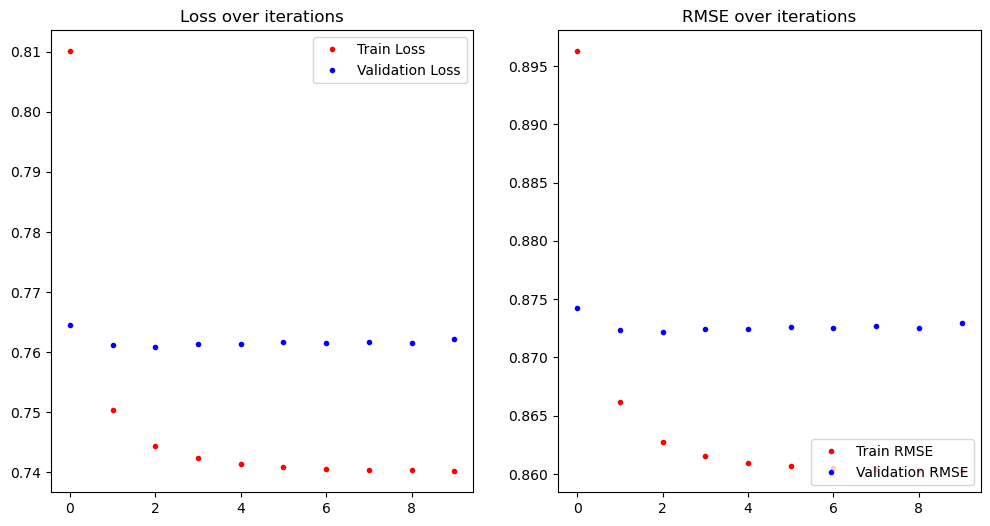

In [21]:
n = len(run_hist.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist.history["root_mean_squared_error"]),'r.', label="Train RMSE")
ax.plot(range(n), (run_hist.history["val_root_mean_squared_error"]),'b.', label="Validation RMSE")
ax.legend(loc='lower right')
ax.set_title('RMSE over iterations')

In [22]:
evaluate = model.evaluate(x=[x_test[:,0], x_test[:,1]], y=y_test)

16874/16874 ━━━━━━━━━━━━━━━━━━━━ 16s 923us/step - loss: 0.7601 - root_mean_squared_error: 0.8717


In [23]:
print('Test loss: ', evaluate[0])
print('Test RMSE: ', evaluate[1])

Test loss:  0.7613482475280762
Test RMSE:  0.8724679350852966


With RMSE of around 0.87, the matrix factorization constructed with Keras performs very similarly to our previus CF models. We can try now to improve it further merging the latent features to a fully connected layer.

## Deep Learning + Matrix Factorization

In the next steps, we combine the power of matrix factirization (MF) with deep learning. Matrix factorization is a linear model, thus it can only learn linear patterns from the dataset. 
We know that artificial neural networks (ANN) can find non-linear patterns. So the idea is to combine both and see if ANN can find residual non-linear patterns neglected by MF.

We repeat the previous step for creating a matrix factorization model, we then concatenate the embedded layers and pass it as input to our ANN with two fully connected layers.

We use the residual learning strategy where the final layers of MF and ANN are added together, and we see if we can capture non-linear patterns neglected by the MF.

In [24]:
# Fully connected layer on concatenated embedding layers
embedding_size = 16 # K

# Define input layers for two sets of data
# The batch_size is implicit, so the input dim is (None,1)
input_user = Input(shape=(1,)) # (None,1)
input_item = Input(shape=(1,)) # (None,1)


# Main model - MF
# Define embedding layer for user
embedding_layer_user = Embedding(input_dim=num_users, output_dim=embedding_size,
                                 embeddings_regularizer=keras.regularizers.l2(1e-2),
                                 name='embedding_layer_user'
                                 )(input_user) # (None,1,K)
# Bias is applied per user, hence output_dim=1
bias_layer_user = Embedding(input_dim=num_users, output_dim=1, 
                            name='bias_layer_user')(input_user) # (None,1,1)
# Define embedding layer for item
embedding_layer_item = Embedding(input_dim=num_items, output_dim=embedding_size,
                                 embeddings_regularizer=keras.regularizers.l2(1e-2),
                                 name='embedding_layer_item'
                                 )(input_item) # (None,1,K)
# Bias is applied per item, hence output_dim=1
bias_layer_item = Embedding(input_dim=num_items, output_dim=1, 
                            name='bias_layer_item')(input_item) # (None,1,1)
# Perform dot product of the two embedded layers
dot_product = Dot(axes=2)([embedding_layer_user, embedding_layer_item]) # (None,1,1)
# Add bias to dot
add_bias = dot_product + bias_layer_user + bias_layer_item # (None,1,1)
# output
output_mf = Flatten()(add_bias) # (None,1)


# Branch model - ANN
dense_size = 32
concat_layers = Concatenate()([embedding_layer_user, embedding_layer_item]) # (None,1,2K)

concat_layers = Flatten()(concat_layers) #(None,2K)
dense_layer1 = Dense(dense_size, activation='relu',
                     name='first_dense_layer',
                     kernel_regularizer=keras.regularizers.L1(1e-2),
                     activity_regularizer=keras.regularizers.L2(1e-2))(concat_layers) # (None,32)
dropout = Dropout(0.3,name='dropout_layer')(dense_layer1)  # (None,32)
dense_layer2 = Dense(dense_size, activation='relu',
                     name='second_dense_layer',
                     kernel_regularizer=keras.regularizers.L1(1e-2),
                     activity_regularizer=keras.regularizers.L2(1e-2))(dropout) # (None,32)
output_ann = Dense(1, activation=None,
                     name='final_layer')(dense_layer2) # (None,1)

# The output of the residual learning model. This part unifies the main model MF with the branch model ANN
residual = output_mf + output_ann # (None,1)

# Create the Keras model
model_rl = Model(inputs=[input_user, input_item], outputs=residual)
opt = keras.optimizers.AdamW(learning_rate=0.003)

# Compile the model
model_rl.compile(optimizer=opt, loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Display the model summary
model_rl.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_us… │ (None, 1, 16)     │  2,198,656 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_it… │ (None, 1, 16)     │     16,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 32)     │          0 │ embedding_layer_… │
│ (Concatenate)       │                   │            │ embedding_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1, 1)      │          0 │ embedding_layer_… │
│                     │                   │            │ embedding_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_layer_user     │ (None, 1, 1)      │    137,416 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_dense_layer   │ (None, 32)        │      1,056 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 1)      │          0 │ dot_1[0][0],      │
│                     │                   │            │ bias_layer_user[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_layer_item     │ (None, 1, 1)      │      1,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 32)        │          0 │ first_dense_laye… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 1)      │          0 │ add_2[0][0],      │
│                     │                   │            │ bias_layer_item[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_dense_layer  │ (None, 32)        │      1,056 │ dropout_layer[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_layer (Dense) │ (None, 1)         │         33 │ second_dense_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1)         │          0 │ flatten_1[0][0],  │
│                     │                   │            │ final_layer[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,355,217 (8.98 MB)

 Trainable params: 2,355,217 (8.98 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
run_hist_rl = model_rl.fit(x=[x_train[:,0],x_train[:,1]], y=y_train, epochs=10, batch_size=256, shuffle=True, validation_split=0.2) 

Epoch 1/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 112s 7ms/step - loss: 0.9633 - root_mean_squared_error: 0.9217 - val_loss: 0.7718 - val_root_mean_squared_error: 0.8740
Epoch 2/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - loss: 0.7536 - root_mean_squared_error: 0.8636 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8724
Epoch 3/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 112s 7ms/step - loss: 0.7443 - root_mean_squared_error: 0.8582 - val_loss: 0.7682 - val_root_mean_squared_error: 0.8722
Epoch 4/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - loss: 0.7413 - root_mean_squared_error: 0.8565 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8723
Epoch 5/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - loss: 0.7415 - root_mean_squared_error: 0.8566 - val_loss: 0.7689 - val_root_mean_squared_error: 0.8725
Epoch 6/10
15187/15187 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - loss: 0.7393 - root_mean_squared_error: 0.8554 - val_loss: 0.7688 - val_root_mean_squared_error: 0.8725
Epoch 7/10
15187

Text(0.5, 1.0, 'RMSE over iterations')

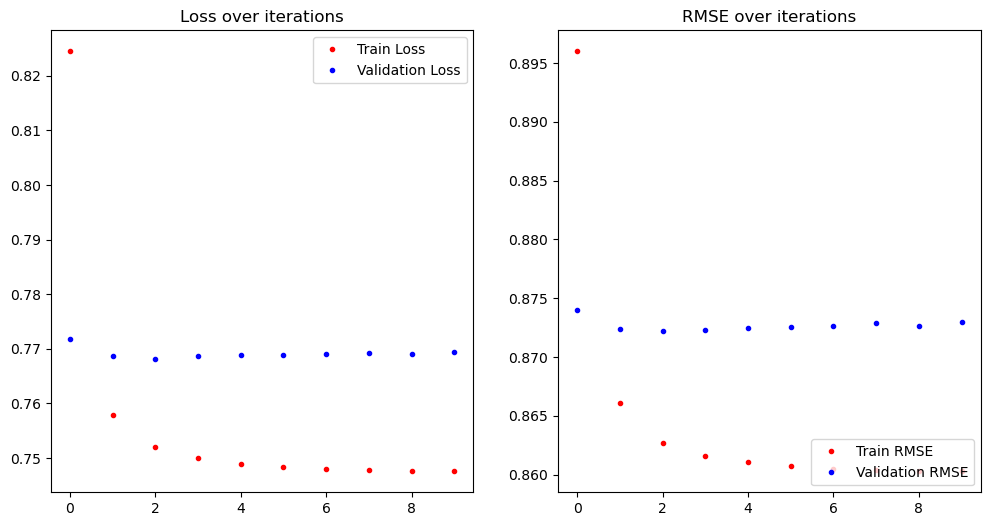

In [26]:
n = len(run_hist_rl.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_rl.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_rl.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_rl.history["root_mean_squared_error"]),'r.', label="Train RMSE")
ax.plot(range(n), (run_hist_rl.history["val_root_mean_squared_error"]),'b.', label="Validation RMSE")
ax.legend(loc='lower right')
ax.set_title('RMSE over iterations')

In [27]:
evaluate_rl = model_rl.evaluate(x=[x_test[:,0], x_test[:,1]], y=y_test)

print('Test loss: ', evaluate_rl[0])
print('Test RMSE: ', evaluate_rl[1])

16874/16874 ━━━━━━━━━━━━━━━━━━━━ 15s 887us/step - loss: 0.7676 - root_mean_squared_error: 0.8719
Test loss:  0.7686367630958557
Test RMSE:  0.8724441528320312


We see here that the RMSE of our residual learning model does not improve on our MF RMSE score. It indicates that there is no non-linear pattern that can be leant by the residuals. 

## Matrix Factorization from Surprise library

As we did before with collaborative filtering, we compare our homemade models with the same ones from the specialized Surprise library.

In [28]:
from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [29]:
sample_items_df = sample_items_df.drop('shifted',axis=1)
sample_items_df.to_csv('sample_df.csv', index=False, header=list(sample_items_df.columns))

In [30]:
# create the reader object with Read on the rating dataset with columns user item rating
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))

# Load the dataset from the CSV file
course_dataset = Dataset.load_from_file("sample_df.csv", reader=reader)

In [31]:
trainset, testset = train_test_split(course_dataset, test_size=.1)

In [32]:
# check how many users and items we can use to fit a KNN model:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the training set")

Total 137218 users and 1000 items in the training set


In [33]:
# Build the NMF model
# An NMF (Non-negative Matrix Factorization) model is instantiated and trained on the training set
model_NMF = NMF(random_state = rs)

# Train the model
model_NMF.fit(trainset)

# Make predictions with NMF on the test set
predictions_nmf = model_NMF.test(testset)

# Evaluate the model
accuracy.rmse(predictions_nmf)

RMSE: 0.8758


0.8757889245584947

And we see that the RMSE is (almost) the same we obtained with Keras!

## Use our model to make recommendations.

We sample 20 random users and make recommendations for them.

In [34]:
sample_items_df.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [35]:
# a list of 20 users we want to provide recommendations
users = sample_items_df['userId'].sample(20, random_state=rs).to_list()

In [36]:
def users_recommend(x,n):
    """
    Function that returns a DataFrame with: users, user interactions, rated movies, n movie recommendations.
    Input: a list of user I want to provide N recommendations. N integer.
    Output: DataFrame

    The sample_items_df, where the model was trained on is implicit.
    """

    users = x # list of users 

    # df is the filtered dataframe where userId.isin(users)
    df = sample_items_df[sample_items_df['userId'].isin(users)]
    
    value_count = df['userId'].value_counts() # pd.Series with total number of items user i have interacted with

    # initiate some list to construct the dictionary later
    interacted = []
    interactions = []
    user_recommend = []

    # movie_all is the set of all movies in the sample_items_df
    movie_all = set(sample_items_df['movieId'].unique()) 

    # look over users
    for i in users:
        # total number of items user i have interacted with
        interactions.append(value_count[i]) 

        # list of items user i has interacted with
        items_i = df[df['userId']==i]['movieId'].to_list() 
        interacted.append(items_i) 

        # list of items user i have not interacted with
        not_interacted = list(movie_all.difference(set(items_i)))

        # before making predictions, we should remind that the [user,item] 
        # passed to model are Label Encoded [user,item], and not original Ids
        x_user = label_encoder_user.transform([i]) # Label encoded user_i
        x_item = label_encoder_item.transform(not_interacted) # Label encoder items user_i have not interacted with

        x_test = [[x_user[0],k] for k in x_item] # [user_i, items] in the same shape as x_train, x_test
        x_test = np.array(x_test)
        
        # we now make preditions using trained model
        pred = model_rl.predict([x_test[:,0],x_test[:,1]]) 

        # make a tuple (item,predict)
        # "label_encoder_item.inverse_transform(x_item)" is equivalent "to not_interacted"
        x_test_pred = [(k, l[0]+mu) for k,l in zip(label_encoder_item.inverse_transform(x_item),pred)] 
        # notice mu was added back to prediction 

        # sort by the second element: predicted rating using key=lambda x:x[1]
        x_test_sorted = sorted(x_test_pred, key=lambda x:x[1], reverse=True)

        # n recommendations for user i from x_test_sorted
        recmm_i = [k[0] for k in x_test_sorted[:n]] 
        user_recommend.append(recmm_i) # append it to recommendation list

    # the dictionary will be used to construct a dataframe user_df
    dic = {'userId':users, 'user interactions':interactions ,'rated movieId':interacted, 'movie recommendations': user_recommend}
    users_df = pd.DataFrame(dic)
    
    return users_df

In [37]:
pd.set_option('max_colwidth', None)

In [38]:
users_df = users_recommend(users, 10)
users_df

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


,userId,user interactions,rated movieId,movie recommendations
0,26926,214,"[1, 3, 4, 5, 7, 11, 12, 15, 19, 21, 29, 32, 39, 44, 47, 50, 52, 58, 63, 64, 65, 70, 85, 87, 92, 93, 101, 102, 104, 107, 110, 111, 118, 122, 141, 144, 147, 150, 152, 153, 156, 160, 162, 168, 170, 172, 180, 181, 185, 186, 195, 196, 203, 204, 208, 216, 218, 223, 231, 234, 235, 236, 237, 239, 248, 252, 253, 255, 258, 260, 288, 292, 296, 300, 303, 312, 316, 318, 319, 325, 327, 328, 329, 330, 337, 339, 342, 344, 349, 350, 351, 353, 355, 356, 357, 364, 366, 367, 368, 370, ...]","[858, 527, 668, 912, 904, 922, 898, 908, 903, 913]"
1,105856,75,"[1, 6, 10, 16, 19, 21, 25, 32, 39, 47, 50, 70, 97, 110, 111, 150, 165, 173, 193, 196, 223, 231, 247, 253, 266, 288, 292, 293, 296, 318, 319, 337, 344, 349, 350, 356, 357, 376, 377, 434, 454, 457, 474, 480, 508, 527, 541, 551, 555, 589, 590, 593, 597, 608, 616, 628, 648, 720, 736, 745, 750, 778, 780, 832, 858, 902, 903, 904, 908, 910, 912, 913, 920, 923, 924]","[668, 922, 898, 930, 926, 665, 306, 213, 632, 905]"
2,126135,64,"[7, 17, 34, 41, 48, 62, 73, 110, 111, 181, 290, 296, 303, 345, 356, 357, 363, 364, 455, 480, 484, 497, 502, 515, 527, 539, 575, 586, 588, 590, 593, 594, 595, 596, 599, 608, 661, 691, 708, 711, 728, 783, 838, 892, 904, 906, 908, 910, 911, 912, 913, 914, 915, 916, 919, 920, 922, 923, 933, 934, 936, 937, 945, 952]","[318, 858, 668, 750, 50, 898, 903, 745, 930, 926]"
3,127247,59,"[1, 6, 16, 21, 25, 32, 47, 50, 58, 101, 105, 110, 111, 125, 150, 161, 215, 223, 253, 296, 306, 308, 318, 346, 356, 357, 364, 377, 380, 431, 457, 480, 517, 527, 539, 541, 555, 589, 590, 593, 595, 597, 608, 628, 648, 733, 778, 780, 858, 903, 906, 910, 912, 919, 920, 930, 931, 968, 1017]","[668, 904, 750, 922, 898, 908, 913, 745, 926, 665]"
4,10365,139,"[1, 6, 10, 11, 17, 21, 25, 30, 32, 34, 36, 39, 41, 45, 46, 47, 48, 50, 69, 70, 80, 85, 110, 117, 120, 123, 135, 144, 145, 150, 154, 163, 165, 175, 190, 194, 195, 199, 213, 223, 228, 232, 235, 237, 241, 247, 248, 253, 260, 272, 277, 288, 290, 296, 301, 305, 309, 310, 317, 318, 321, 326, 344, 349, 352, 353, 356, 357, 364, 368, 377, 380, 414, 429, 438, 440, 441, 446, 456, 457, 458, 460, 474, 480, 493, 497, 500, 508, 509, 511, 514, 517, 519, 523, 527, 532, 534, 539, 541, 544, ...]","[858, 668, 912, 904, 750, 922, 898, 908, 903, 913]"
5,126443,150,"[1, 5, 6, 7, 10, 11, 16, 17, 22, 24, 26, 27, 32, 36, 39, 41, 43, 45, 46, 47, 48, 62, 64, 70, 86, 89, 95, 107, 110, 141, 150, 153, 160, 168, 185, 188, 196, 203, 207, 208, 218, 222, 234, 249, 253, 256, 260, 261, 266, 273, 276, 280, 282, 292, 296, 300, 317, 329, 343, 345, 346, 349, 350, 356, 357, 364, 366, 367, 368, 372, 374, 375, 377, 386, 405, 410, 412, 423, 435, 440, 446, 450, 454, 455, 457, 468, 471, 474, 475, 480, 491, 497, 500, 502, 507, 508, 512, 515, 517, 520, ...]","[318, 858, 668, 912, 904, 50, 922, 898, 908, 903]"
6,132185,170,"[1, 2, 5, 6, 10, 11, 12, 16, 17, 19, 20, 21, 22, 32, 34, 36, 39, 44, 47, 50, 60, 63, 65, 66, 69, 70, 93, 95, 101, 104, 110, 111, 145, 150, 153, 163, 165, 172, 173, 174, 180, 181, 185, 196, 203, 208, 216, 223, 231, 235, 253, 256, 260, 266, 267, 276, 288, 293, 296, 303, 316, 318, 319, 328, 329, 332, 333, 337, 339, 342, 344, 353, 355, 356, 357, 364, 367, 368, 370, 372, 374, 377, 379, 380, 382, 386, 393, 397, 405, 410, 434, 435, 436, 440, 441, 442, 454, 457, 460, 464, ...]","[668, 922, 898, 745, 930, 926, 665, 306, 213, 632]"
7,53029,135,"[1, 2, 5, 7, 10, 11, 13, 21, 25, 32, 34, 39, 48, 50, 52, 58, 62, 86, 104, 110, 135, 140, 141, 150, 153, 158, 160, 161, 163, 168, 185, 205, 208, 224, 225, 231, 249, 252, 256, 260, 262, 288, 301, 316, 318, 329, 333, 337, 339, 344, 349, 356, 357, 362, 364, 367, 368, 371, 372, 376, 377, 380, 383, 410, 440, 442, 454, 455, 457, 468, 471, 474, 480, 485, 497, 500, 517, 527, 529, 534, 539, 543, 551, 585, 587, 588, 589, 590, 592, 594, 595, 596, 597, 603, 605, 608, 648, 653, 661, 671, ...]","[668, 904, 922, 898, 913, 745, 930, 926, 665, 306]"
8,52862,7,"[180, 193, 273, 362, 531, 719, 849]","[31

The dataframe show 10 recommendation to each of the 20 selected users